In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearnex import patch_sklearn, unpatch_sklearn

patch_sklearn()
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
data_file = "../../data/HousingData.csv"
houseDF = pd.read_csv(data_file)
houseDF.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     486 non-null    float64
 1   ZN       486 non-null    float64
 2   INDUS    486 non-null    float64
 3   CHAS     486 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      486 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    486 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [15]:
houseDF_drop = houseDF.dropna()
houseDF_drop.info()


<class 'pandas.core.frame.DataFrame'>
Index: 394 entries, 0 to 504
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     394 non-null    float64
 1   ZN       394 non-null    float64
 2   INDUS    394 non-null    float64
 3   CHAS     394 non-null    float64
 4   NOX      394 non-null    float64
 5   RM       394 non-null    float64
 6   AGE      394 non-null    float64
 7   DIS      394 non-null    float64
 8   RAD      394 non-null    int64  
 9   TAX      394 non-null    int64  
 10  PTRATIO  394 non-null    float64
 11  B        394 non-null    float64
 12  LSTAT    394 non-null    float64
 13  MEDV     394 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 46.2 KB


In [16]:
featureDF = houseDF_drop.drop(["MEDV"], axis=1)
targetSR = houseDF_drop["MEDV"]


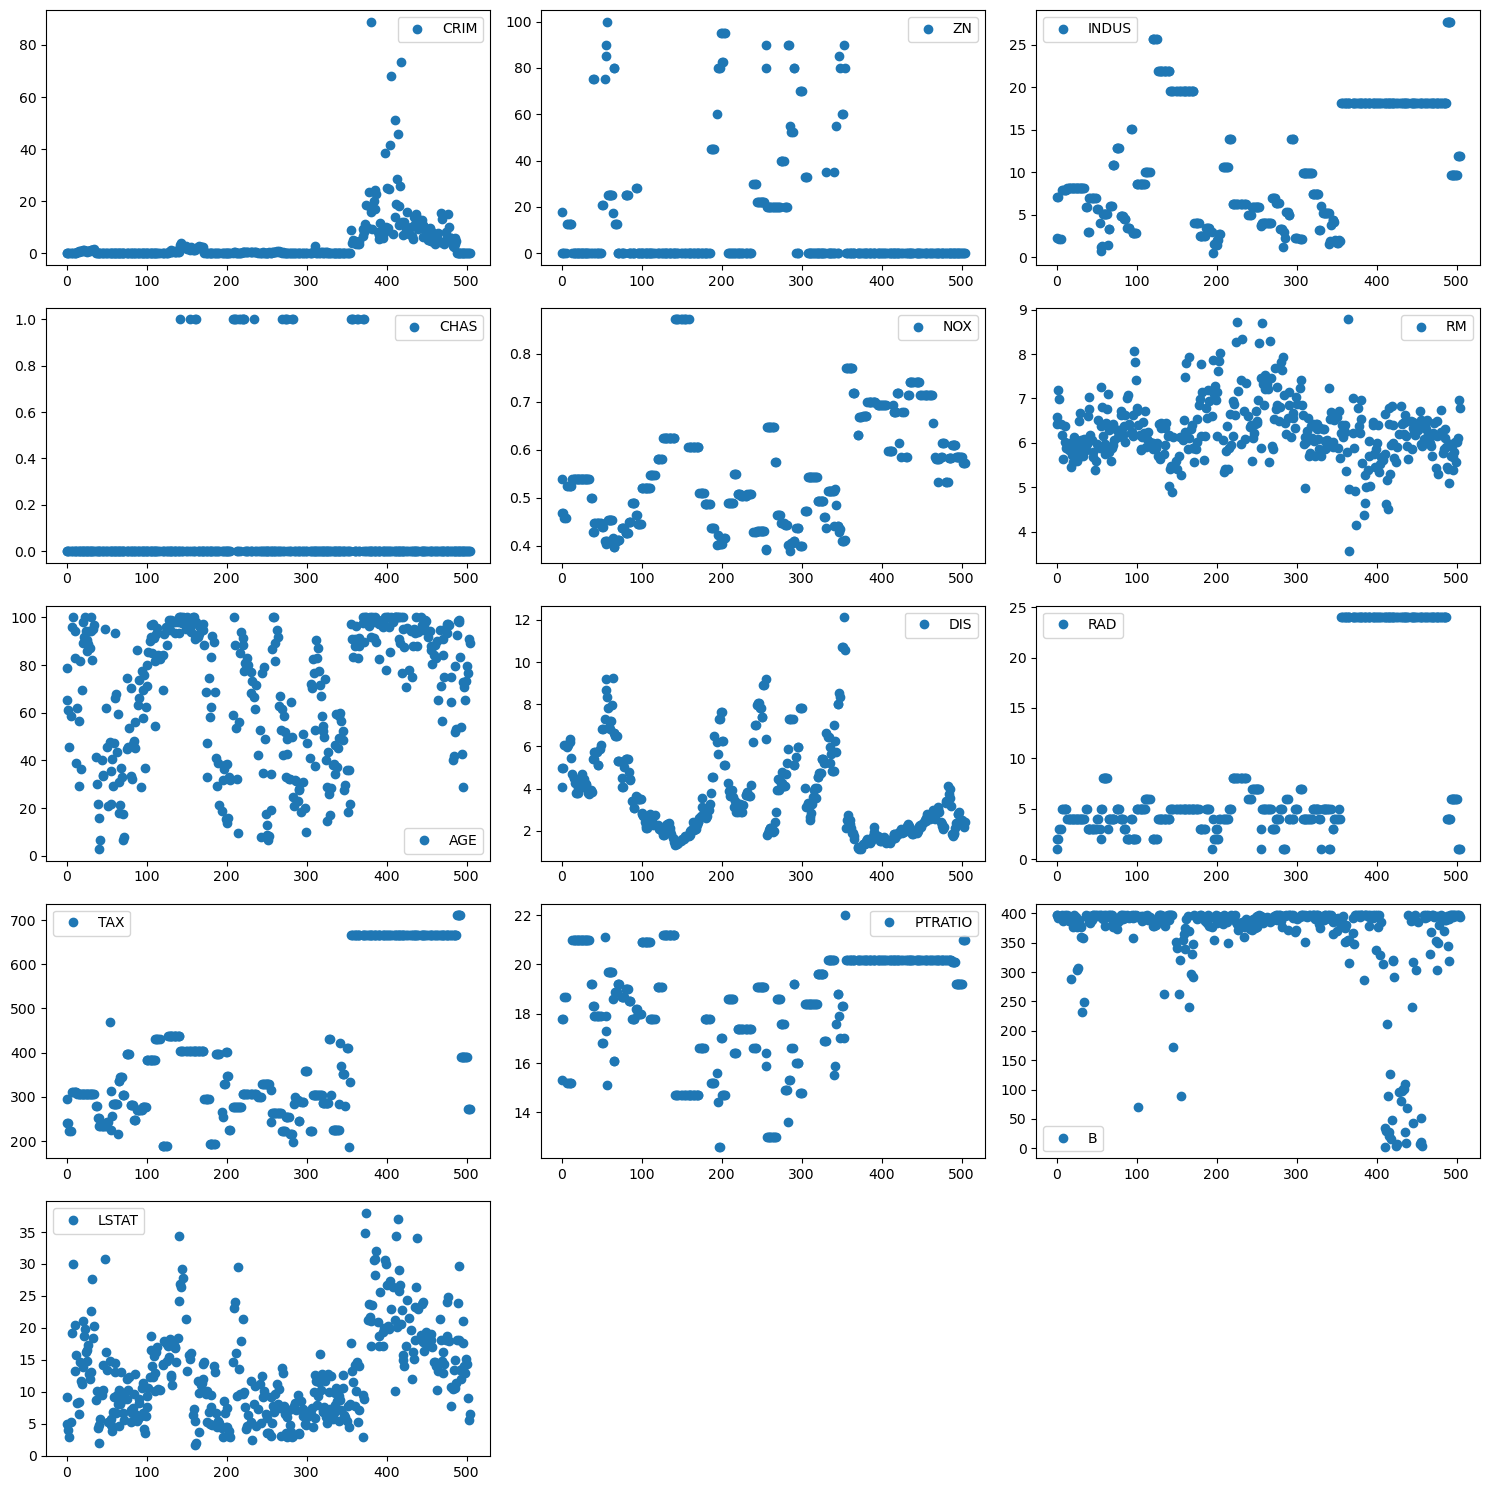

In [20]:
plt.figure(figsize=(15, 15))
for idx, col in enumerate(featureDF.columns, 1):
    plt.subplot(5, 3, idx)
    plt.plot(featureDF[col], "o", label=col)
    plt.legend()
plt.tight_layout()
plt.show()


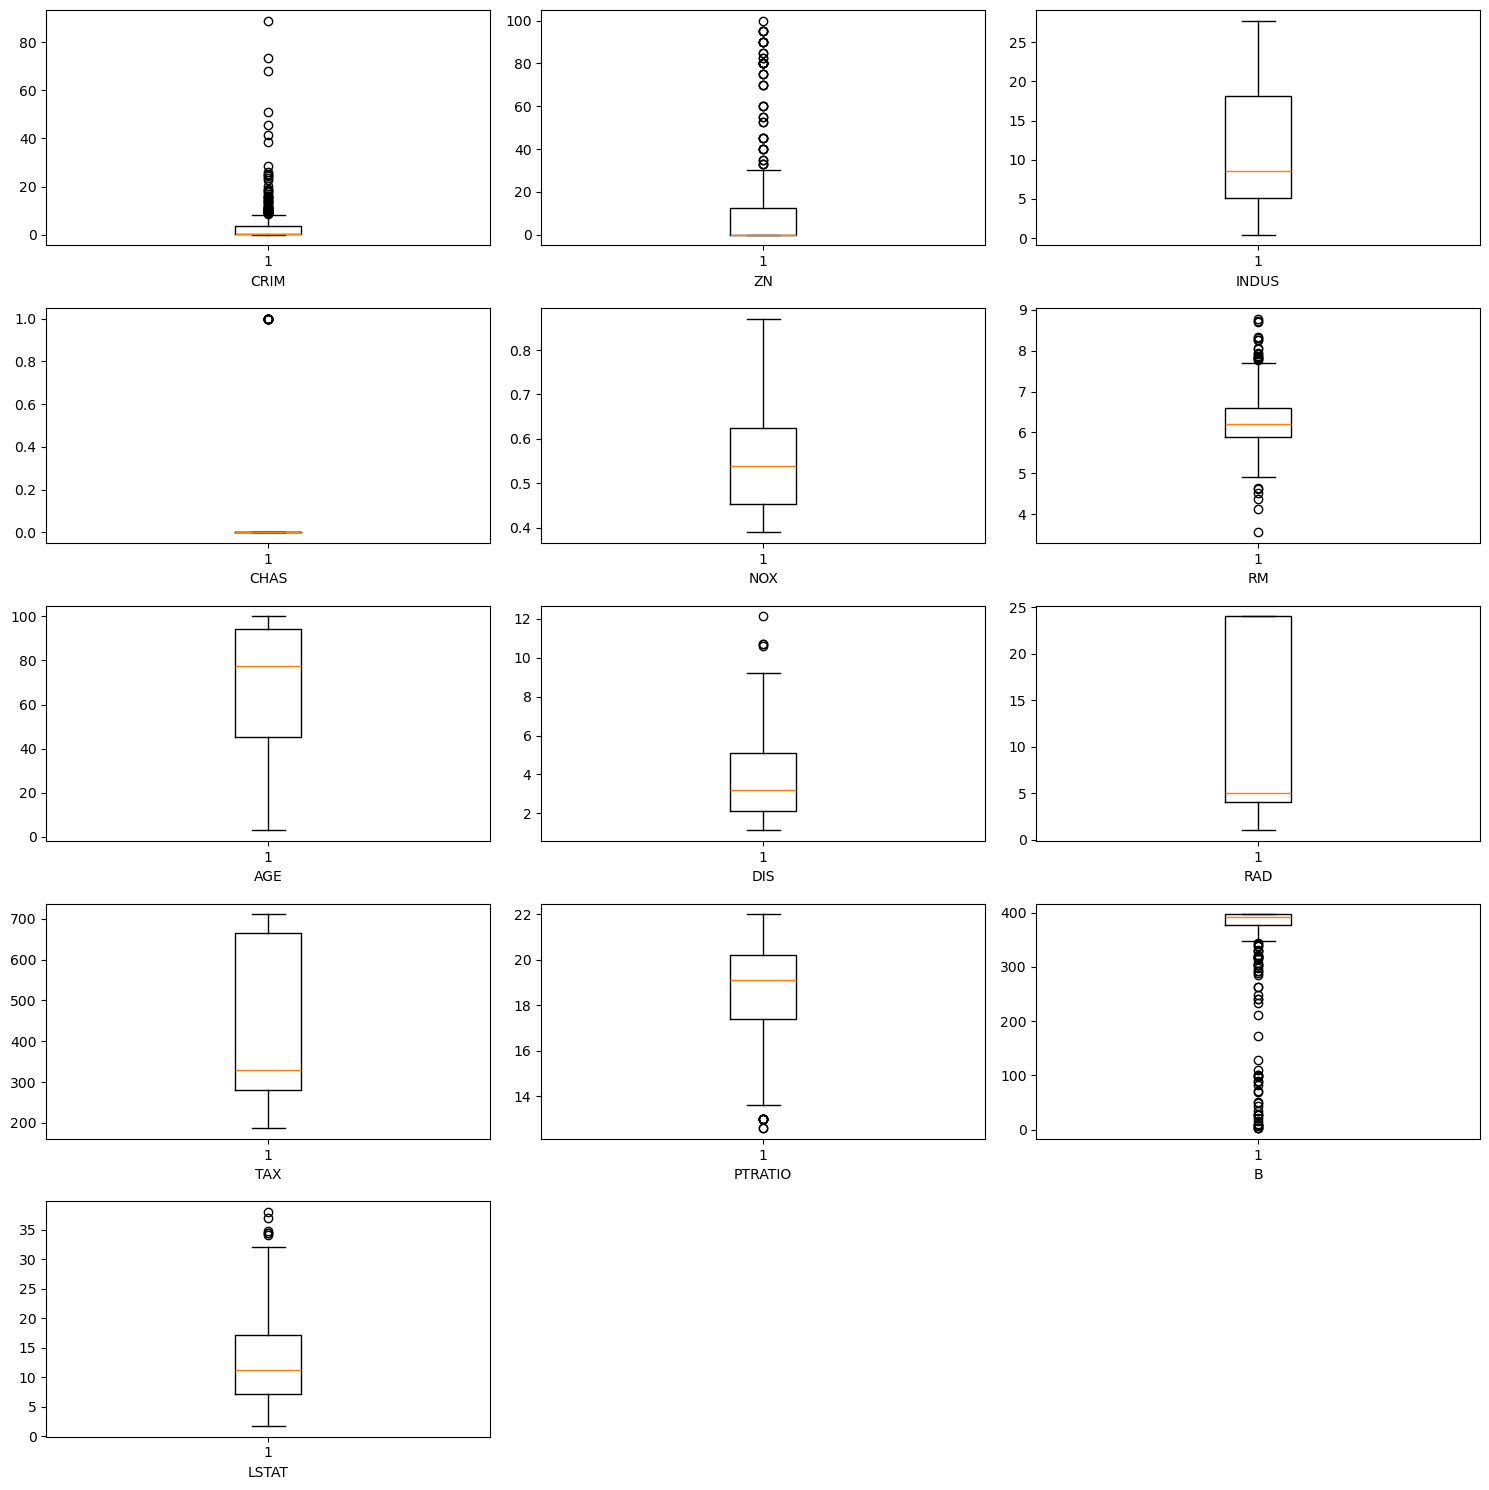

In [21]:
plt.figure(figsize=(15, 15))
for idx, col in enumerate(featureDF.columns, 1):
    plt.subplot(5, 3, idx)
    plt.boxplot(featureDF[col])
    plt.xlabel(col)
plt.tight_layout()
plt.show()


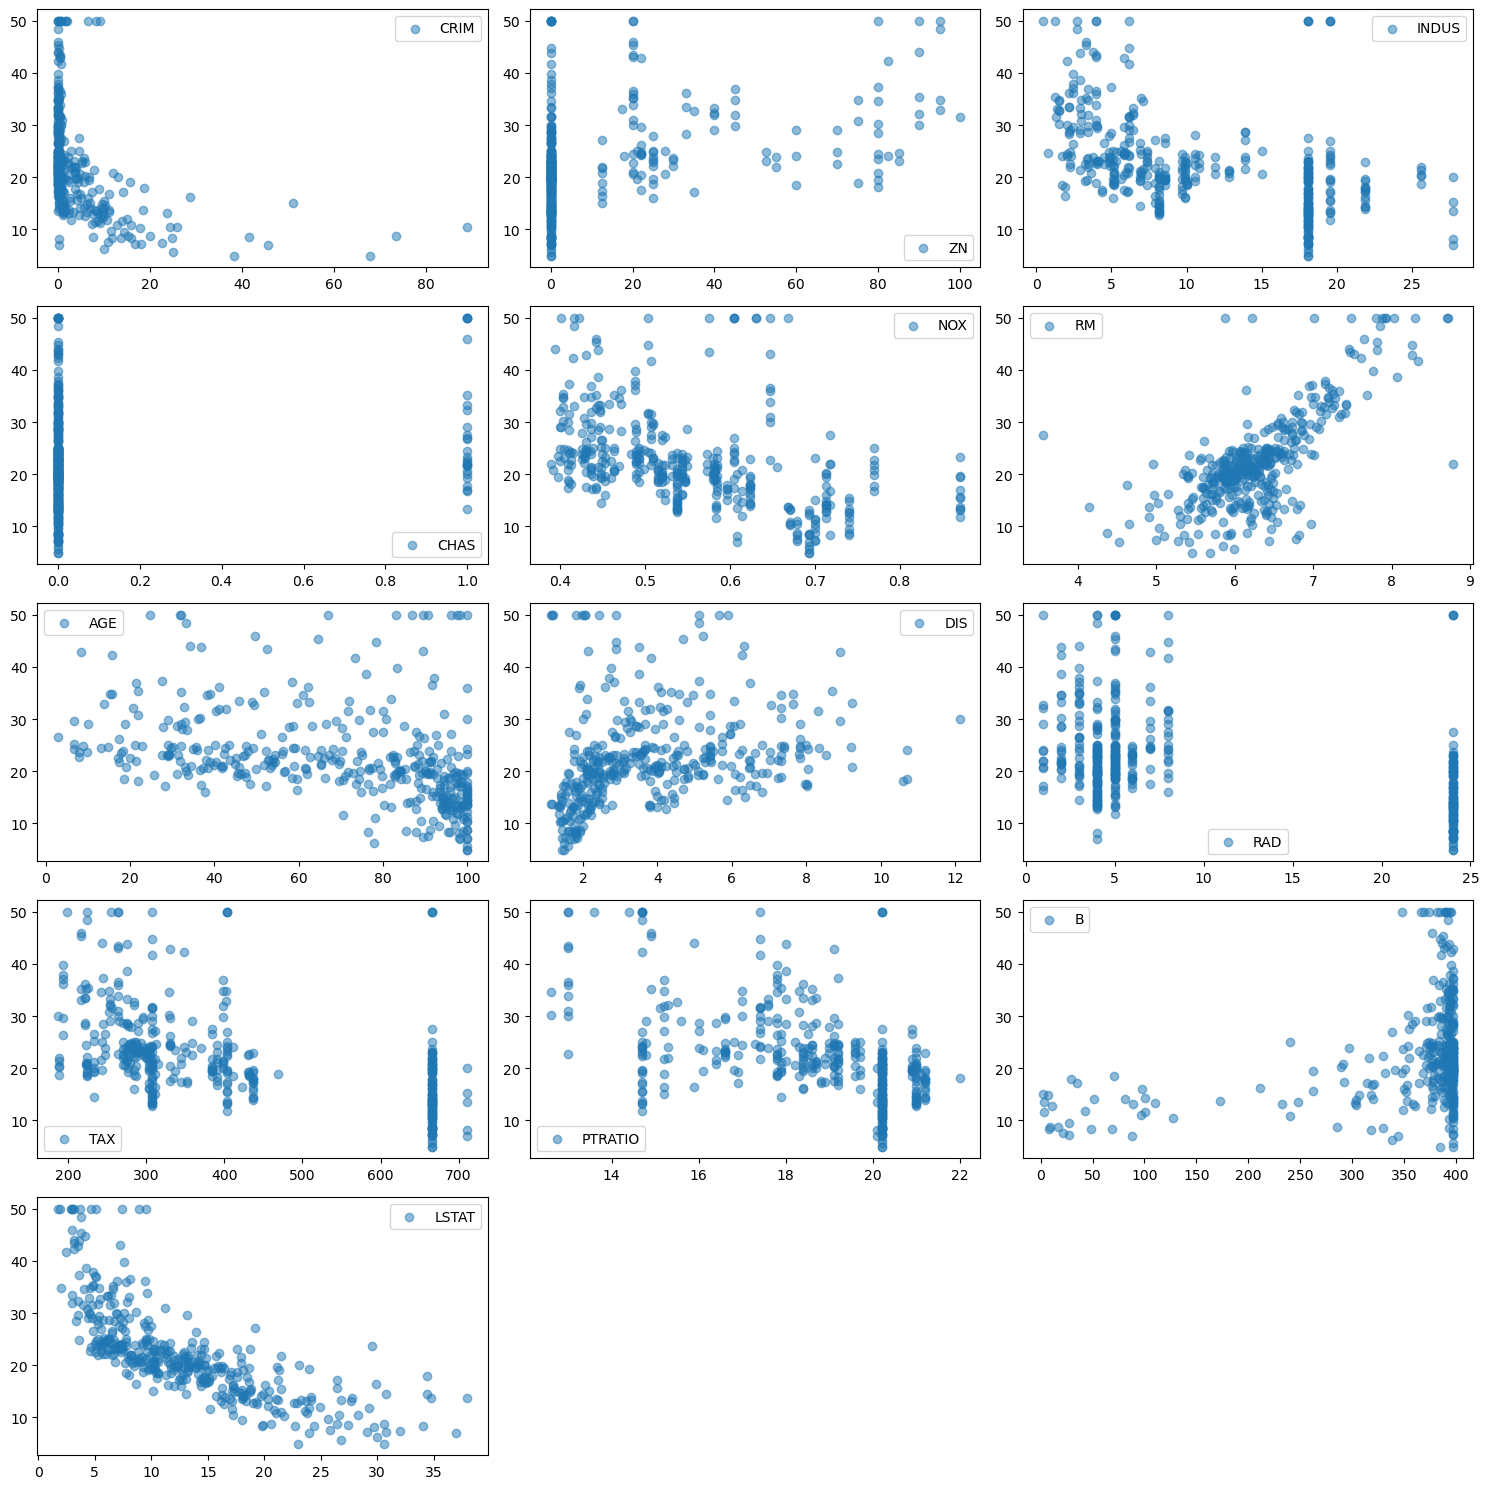

In [22]:
plt.figure(figsize=(15, 15))
for idx, col in enumerate(featureDF.columns, 1):
    plt.subplot(5, 3, idx)
    plt.scatter(featureDF[col], targetSR, alpha=0.5, label=col)
    plt.legend()
plt.tight_layout()
plt.show()


In [23]:
x_train, x_test, y_train, y_test = train_test_split(
    featureDF, targetSR, test_size=0.2, random_state=42
)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)


(315, 13) (79, 13) (315,) (79,)


In [28]:
scalers = []
scalers.append(StandardScaler().fit(x_train))
scalers.append(MinMaxScaler().fit(x_train))
scalers.append(RobustScaler().fit(x_train))


In [27]:
models = []
models.append(LinearRegression())
models.append(Ridge())
models.append(Lasso())


In [67]:
modelDict = {}
i = 0
for scaler in scalers:
    scaled_x_train = scaler.transform(x_train)
    scaled_x_test = scaler.transform(x_test)
    for model in models:
        if model.__class__.__name__ == "LinearRegression":
            params = {"fit_intercept": [True, False]}
        else:
            params = {"alpha": np.logspace(-4, 0, 100)}

        try:
            grd_model = GridSearchCV(
                model,
                param_grid=params,
                scoring=("neg_root_mean_squared_error"),
                return_train_score=True,
            )
            grd_model.fit(scaled_x_train, y_train)
            modelDict[i] = {
                "scaler": scaler.__class__.__name__,
                "model": model.__class__.__name__,
                "best_estimator": grd_model.best_estimator_,
                "best_score": grd_model.best_score_,
                "best_params": grd_model.best_params_,
            }
            i += 1
        except Exception as e:
            print("\033[91m", e, "\033[0m\n")


In [68]:
modelDF = pd.DataFrame(modelDict).T
modelDF.sort_values(by="best_score", ascending=False, inplace=True)
modelDF.reset_index(drop=True, inplace=True)
modelDF


,scaler,model,best_estimator,best_score,best_params
0,MinMaxScaler,Ridge,Ridge(alpha=0.4750810162102798),-4.412182,{'alpha': 0.4750810162102798}
1,RobustScaler,Ridge,Ridge(),-4.436943,{'alpha': 1.0}
2,StandardScaler,Ridge,Ridge(),-4.442213,{'alpha': 1.0}
3,RobustScaler,Lasso,Lasso(alpha=0.013848863713938732),-4.442254,{'alpha': 0.013848863713938732}
4,StandardScaler,Lasso,Lasso(alpha=0.026560877829466867),-4.442356,{'alpha': 0.026560877829466867}
5,MinMaxScaler,Lasso,Lasso(alpha=0.006579332246575682),-4.443124,{'alpha': 0.006579332246575682}
6,MinMaxScaler,LinearRegression,LinearRegression(),-4.448856,{'fit_intercept': True}
7,StandardScaler,LinearRegression,LinearRegression(),-4.448856,{'fit_intercept': True}
8,RobustScaler,LinearRegression,LinearRegression(),-4.448856,{'fit_intercept': True}


In [69]:
best_model = modelDF["best_estimator"][0]
best_model.fit(scaled_x_train, y_train)


Ridge(alpha=0.4750810162102798)

In [70]:
best_model.score(scaled_x_train, y_train), best_model.score(scaled_x_test, y_test)


(0.7975105492060012, 0.6251999820928622)